In [1]:
import torch
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
from util.util import TwoCropTransform
from util.util_diff import DiffLoader, DiffTransform
from util.util_diff import SameTwoRandomResizedCrop, SameTwoColorJitter, SameTwoApply

In [201]:
import torch.nn.functional as nnf

class ShufflePatches:
    # inspired from https://stackoverflow.com/questions/66962837/shuffle-patches-in-image-batch
    def __init__(self, patch_size):
        self.patch_size = patch_size

    def __call__(self, x):
        # unfold the tensor image
        u = nnf.unfold(x, kernel_size=self.patch_size , stride=self.patch_size , padding=0)
        # shuffle the patches in unfolded form
        pu = u[:,torch.randperm(u.shape[-1])]
        # fold the tensor back in its original form
        f = nnf.fold(pu, x.shape[-2:], kernel_size=self.patch_size, stride=self.patch_size, padding=0)

        return f

In [202]:
def set_loader(diff=False, aug=['resizedCrop', 'horizontalFlip', 'colorJitter', 'grayscale'],
               resizedCrop=[0.2, 1.0, 3/4, 4/3], horizontalFlip=0.5, colorJitter=[0.8, 0.4, 0.4, 0.4, 0.4], grayscale=0.2):
    # construct data loader
    # for animasl10 300x300
    mean = (0.3837, 0.3704, 0.3072)
    std = (0.3268, 0.3187, 0.3051)
    normalize = transforms.Normalize(mean=mean, std=std)

    train_same_transform = None
    same_transform_list = []
    if 'sameResizedCrop' in aug:
        scaleMin, scaleMax, ratioMin, ratioMax = resizedCrop
        same_transform_list.append(SameTwoRandomResizedCrop(size=300, scale=(scaleMin, scaleMax), ratio=(ratioMin, ratioMax)))
    if 'sameHorizontalFlip' in aug:
        same_transform_list.append(transforms.RandomApply([
            SameTwoApply(transforms.RandomHorizontalFlip(p=1.0))
        ], p=horizontalFlip))
    if 'sameColorJitter' in aug:
        pJitter, brightness, contrast, saturation, hue = colorJitter
        same_transform_list.append(transforms.RandomApply([
            SameTwoColorJitter(brightness, contrast, saturation, hue)
        ], p=pJitter))
    if 'sameGrayscale' in aug:
        same_transform_list.append(transforms.RandomApply([
            SameTwoApply(transforms.RandomGrayscale(p=1.0))
        ], p=grayscale))
    if len(same_transform_list) > 0:
        train_same_transform = transforms.Compose(same_transform_list)

    transform_list = []
    if 'resizedCrop' in aug:
        scaleMin, scaleMax, ratioMin, ratioMax = resizedCrop
        transform_list.append(transforms.RandomResizedCrop(size=300, scale=(scaleMin, scaleMax), ratio=(ratioMin, ratioMax)))
    if 'horizontalFlip' in aug:
        transform_list.append(transforms.RandomHorizontalFlip(p=horizontalFlip))
    if 'colorJitter' in aug:
        pJitter, brightness, contrast, saturation, hue = colorJitter
        transform_list.append(transforms.RandomApply([
            transforms.ColorJitter(brightness, contrast, saturation, hue)
        ], p=pJitter))
    if 'grayscale' in aug:
        transform_list.append(transforms.RandomGrayscale(p=grayscale))
    transform_list.extend([
        transforms.ToTensor(),
        normalize
    ])

    if 'shufflePatches' in aug:
        transform_list.append(ShufflePatches(patch_size=30))


    train_transform = transforms.Compose(transform_list)

    if diff:
        train_dataset = datasets.ImageFolder(root="./datasets/animals10_diff/-1/train/",
                                     loader=DiffLoader(path_orig="./datasets/animals10_diff/-1/train/", path_diff="./datasets/animals10_diff/4000/train/"),
                                     transform=DiffTransform(train_transform, train_same_transform))
    else:
        train_dataset = datasets.ImageFolder(root="./datasets/animals10_300x300/train/",
                                            transform=TwoCropTransform(train_transform, train_same_transform))
    
    train_sampler = None
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=4, shuffle=(train_sampler is None),
        num_workers=4, pin_memory=True, sampler=train_sampler)

    return train_loader


def plot_batch(train_loader):

    fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(12,20))
    fig.tight_layout(pad=0)

    for idx, (images, labels) in enumerate(train_loader):
        print(labels)
        for i, t_images in enumerate(images):
            for j, image in enumerate(t_images):
                im_min = image.min()
                im2 = image - im_min
                im3 = im2 / im2.max()
                im4 = torch.stack((im3[0,:,:],im3[1,:,:],im3[2,:,:]),dim=2)
                axs[j,i].imshow(im4)
                axs[j,i].set_title(f"{labels[j]}")
                axs[j,i].set_axis_off()
        break

In [205]:
train_loader = set_loader(diff=True, aug=['shufflePatches'])

tensor([7, 0, 1, 4])


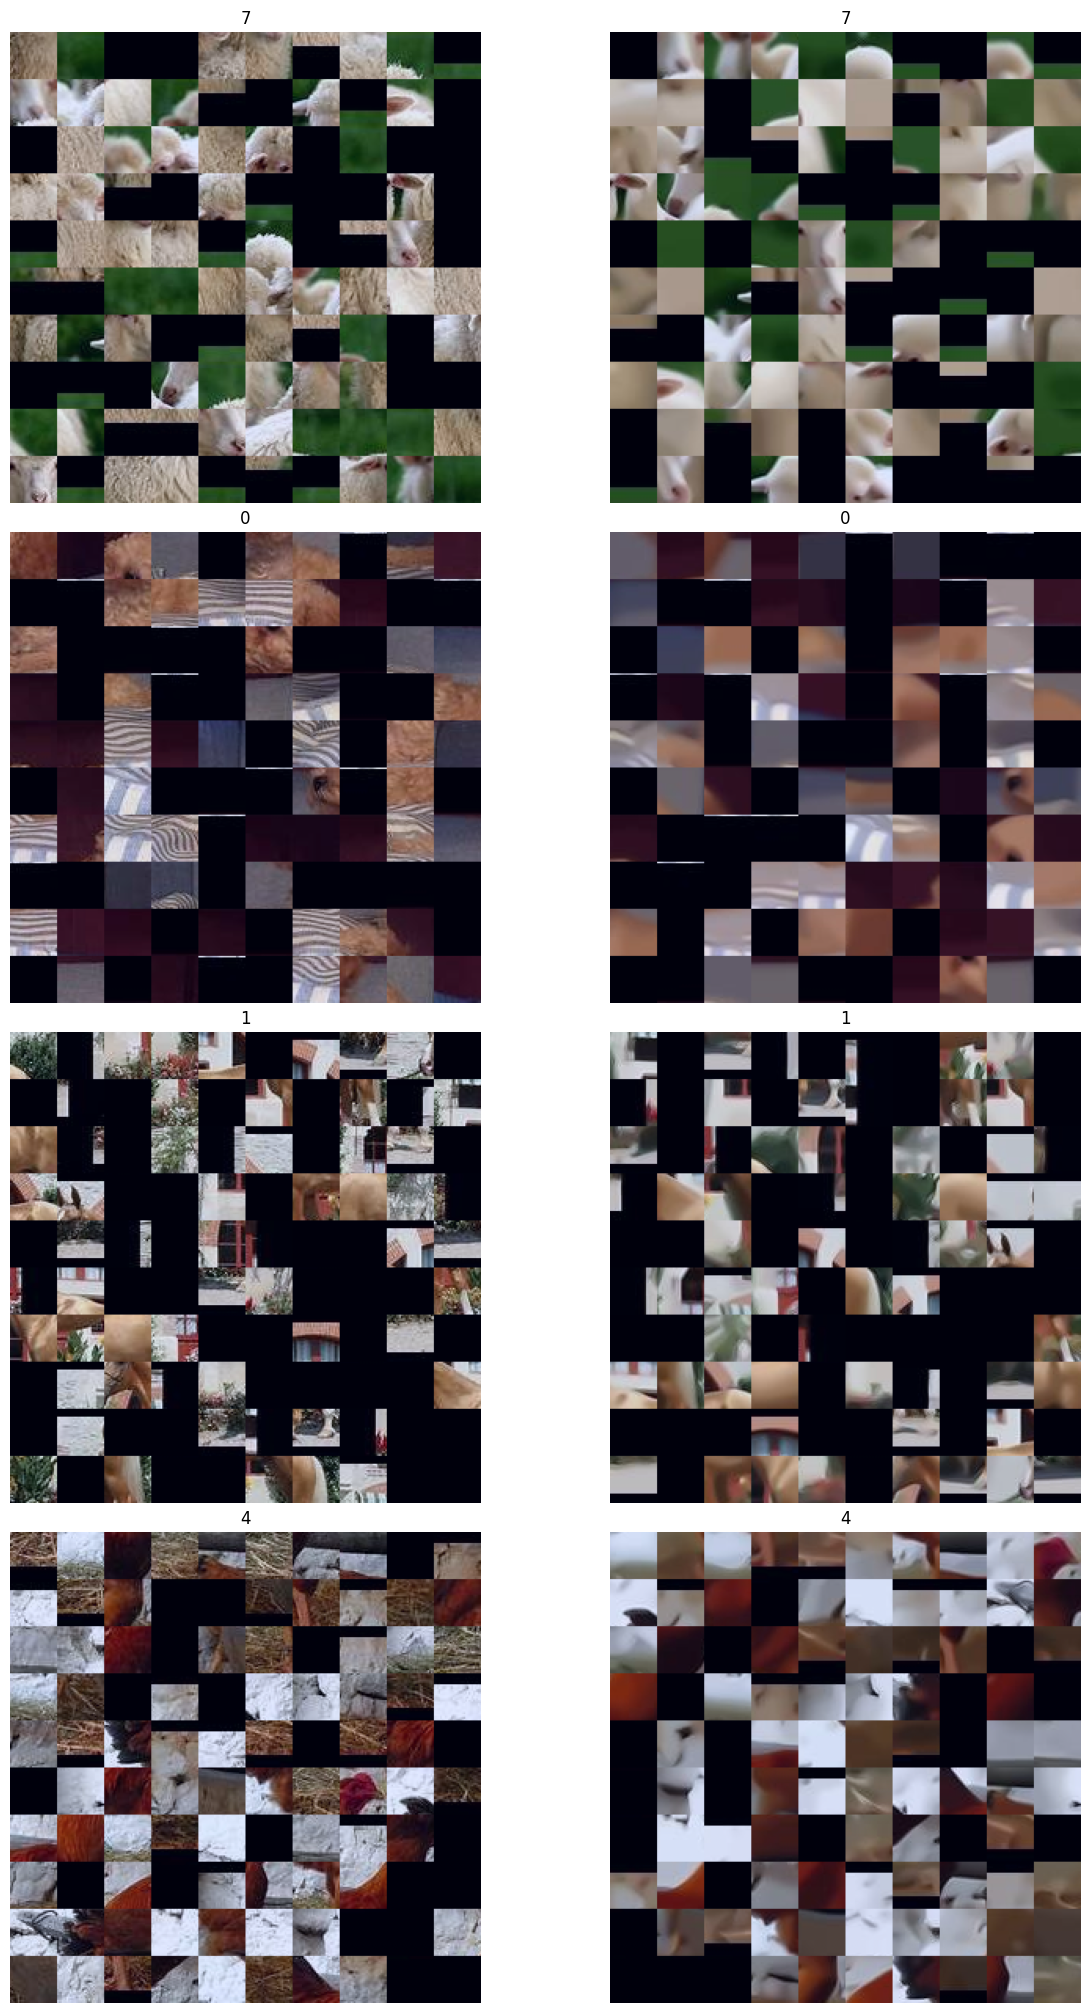

In [206]:
plot_batch(train_loader)

--------

In [3]:
# train_loader = set_loader(diff=False)# OK
# train_loader = set_loader(diff=False, aug=[])# OK
# train_loader = set_loader(diff=False, aug=['resizedCrop'])# OK
# train_loader = set_loader(diff=False, aug=['horizontalFlip'])# OK
# train_loader = set_loader(diff=False, aug=['colorJitter'])# OK
# train_loader = set_loader(diff=False, aug=['grayscale'])# OK

# train_loader = set_loader(diff=False, aug=['sameResizedCrop'])# OK
# train_loader = set_loader(diff=False, aug=['sameHorizontalFlip'])# OK
# train_loader = set_loader(diff=False, aug=['sameColorJitter'])# OK
# train_loader = set_loader(diff=False, aug=['sameGrayscale'], grayscale=0.5)# OK

# train_loader = set_loader(diff=False, aug=['sameResizedCrop', 'sameHorizontalFlip', 'sameColorJitter', 'sameGrayscale'])# OK

In [6]:
# train_loader = set_loader(diff=True)# OK
train_loader = set_loader(diff=True, aug=[])# OK
# train_loader = set_loader(diff=True, aug=['resizedCrop'])# OK
# train_loader = set_loader(diff=True, aug=['horizontalFlip'])# OK
# train_loader = set_loader(diff=True, aug=['colorJitter'])# OK
# train_loader = set_loader(diff=True, aug=['grayscale'])# OK

# train_loader = set_loader(diff=True, aug=['sameResizedCrop'])# OK
# train_loader = set_loader(diff=True, aug=['sameHorizontalFlip'])# OK
# train_loader = set_loader(diff=True, aug=['sameColorJitter'])
# train_loader = set_loader(diff=True, aug=['sameGrayscale'], grayscale=0.5)# OK

# train_loader = set_loader(diff=True, aug=['sameResizedCrop', 'sameHorizontalFlip', 'sameColorJitter', 'sameGrayscale'])# OK

train_loader = set_loader(diff=True, aug=['sameResizedCrop', 'sameHorizontalFlip', 'colorJitter', 'grayscale'],
                          resizedCrop=[0.4, 1, 3/4, 4/3])

tensor([2, 0, 8, 7])


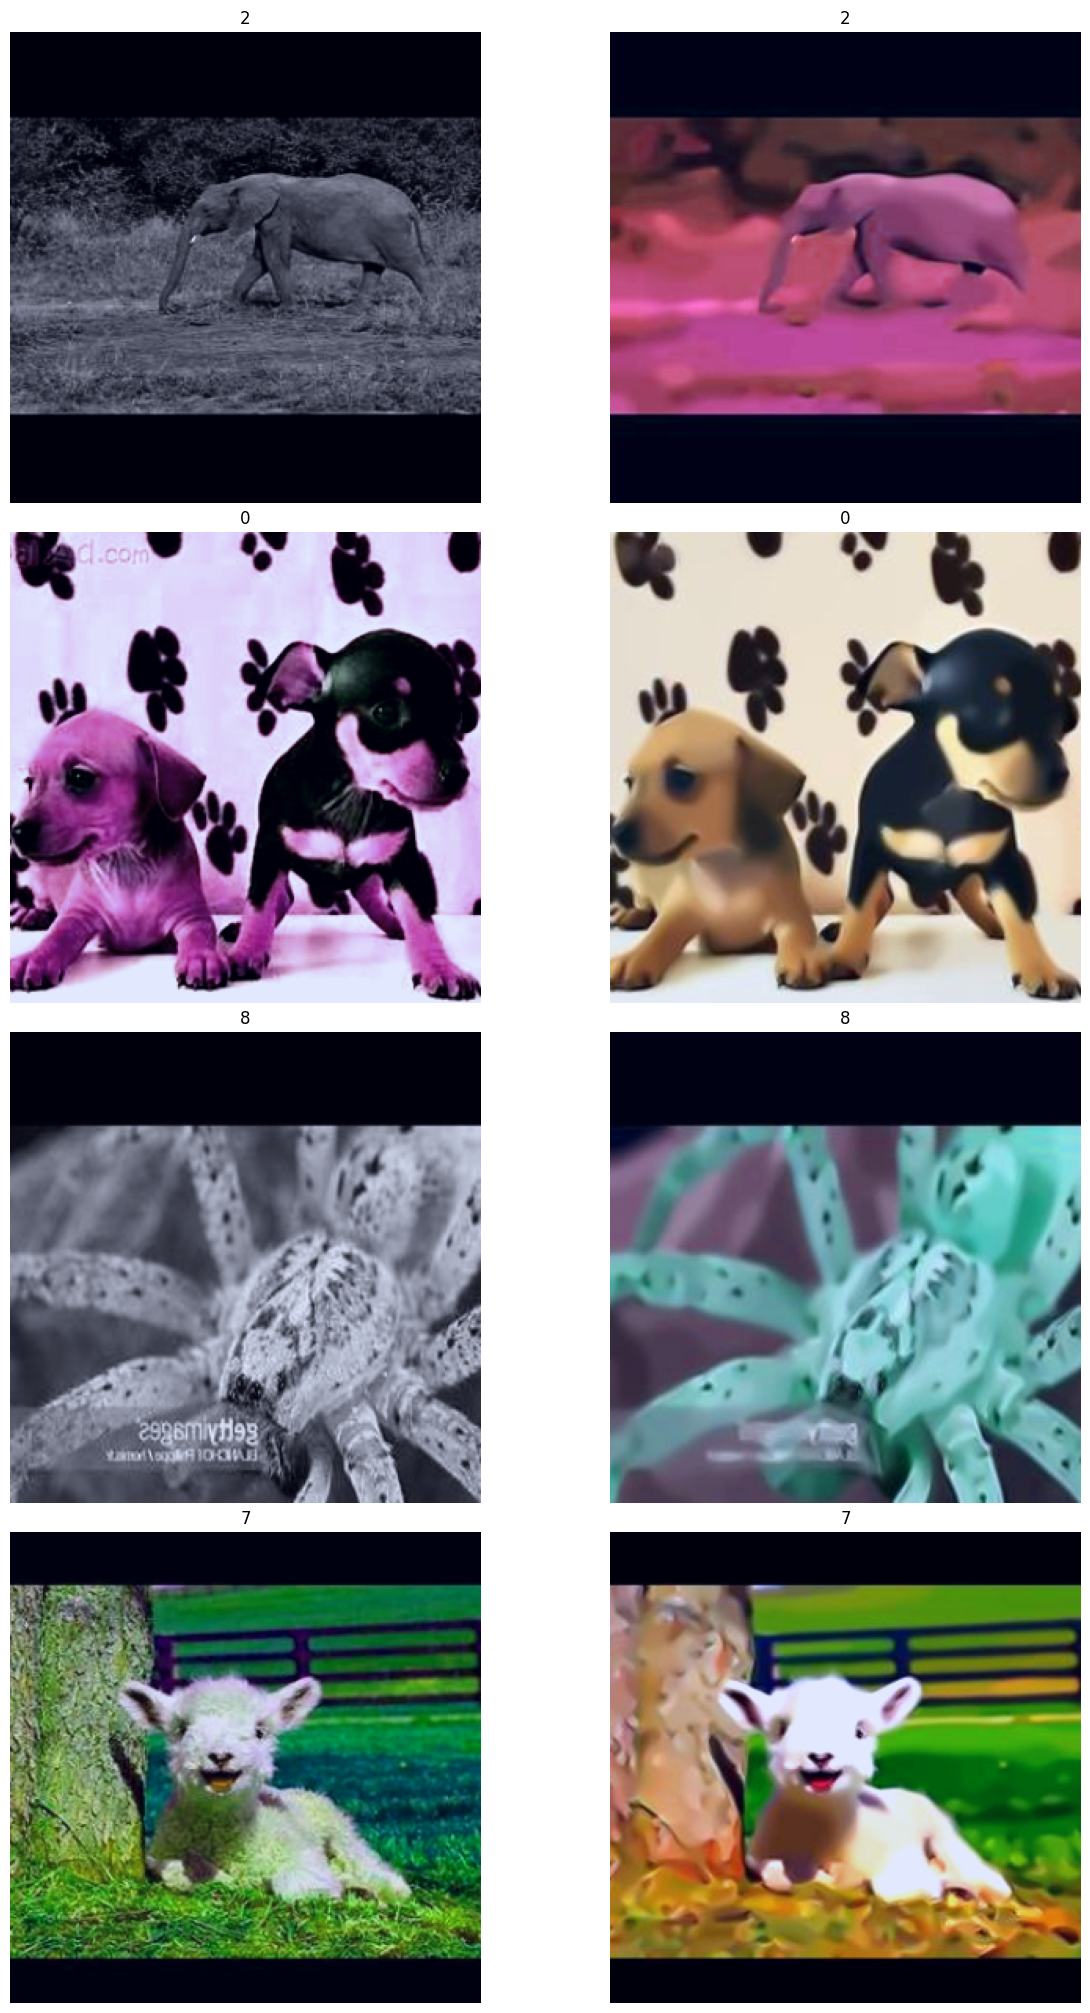

In [7]:
plot_batch(train_loader)